In [0]:
#Headers Definition
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

###Loading and splitting the data (Train/ Test/ Validate):

In [0]:
#Transformations
transform = transforms.Compose([      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ]) #normalize each channel =>image = (image - mean) / std


#loading the data and preprocessing it
CIFAR_train= torchvision.datasets.CIFAR10("./data",train=True, download=True, transform=transform) #Training Data
CIFAR_test= torchvision.datasets.CIFAR10("./data",train=False, download=True, transform=transform) #Testing Data

#Create Validation Set
indices = list(range(len(CIFAR_train)))
np.random.shuffle(indices)

split = int(np.floor(0.9 * len(CIFAR_train)))
tr_idx, val_idx = indices[:split], indices[split:]

tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)

# random_split() Issues: 
#tr, val = torch.utils.data.random_split(CIFAR_train, [int(len(CIFAR_train) * 0.9), int(len(CIFAR_train) * 0.1)])  

#How are we gonna iterate over the data?
train_loader= torch.utils.data.DataLoader(CIFAR_train,batch_size=4,sampler=tr_sampler) #batch_size : process the data in batches and make a better generalization
valid_loader= torch.utils.data.DataLoader(CIFAR_train,batch_size=4,sampler=val_sampler)
test_loader= torch.utils.data.DataLoader(CIFAR_test,batch_size=4,shuffle=False)  #shuffling the data makes a better generalization

# data labels
labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#each data has 4 images

Files already downloaded and verified
Files already downloaded and verified


###This cell is only for checking the visuals for one picture (You can skip this): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32])
horse


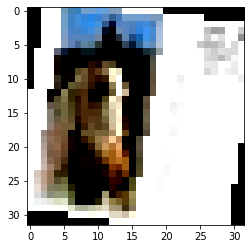

In [0]:
import matplotlib.pyplot as plt
import numpy as np

#every type you run this it is shuffled
for data in train_loader:
  print(data[0].shape)  # batch_size, # channels, #height, #width
  break

# show images
plt.imshow(np.transpose(data[0][0], (1, 2, 0))) #replace 0 with 1 axis and 1 with 2 and 2 with 0  -> output: height,width ,channel
plt.show
print(labels[data[1][0]])

###Neural Network Definition:

In [0]:
class Net(nn.Module):

  def __init__(self):
    super().__init__() #initialize your network
    self.fc1=nn.Linear(32*32*3, 256) #32*32*3 -> first flattened image and fully connected layer
    self.fc2=nn.Linear(256, 32) # second layer
    self.fc3=nn.Linear(32, 10) #output layer has 10 neurons
    
  def forward(self,x):
    x=F.relu(self.fc1(x)) # apply the activation function
    x=F.relu(self.fc2(x)) # apply the activation function
    x=self.fc3(x) # apply the activation function either zero or one ! so one of the node is fired 
    return F.log_softmax(x,dim=1)
    #this function will return for each picture: 10 nodes (prediction value of each label)

###Driver Code:

In [0]:
net=Net() #model
optimizer=optim.Adam(net.parameters(),lr=0.001) #get adjustable parameters(weights) and optimize them
criterion = nn.CrossEntropyLoss()
total_epoch=30 #How many times we pass our full data (the same data)

###Training and Validation:

In [0]:
for cur_epoch in range(total_epoch):
  train_correct=0
  train_total=0
  train_loss=0 #loss per epoch

  valid_correct=0
  valid_total=0
  valid_loss=0 #loss per epoch
  
  for data in train_loader:
    #every data consits of 4 (batch_size) images
    X,y=data #picture(X batch_size), label(X batch_size) -> #batch size comes first #note that the label here is a number which is index in labels list
    net.zero_grad()  
    output = net(X.view(-1,32*32*3))  
    loss = criterion(output, y) #calculate the error/ loss for the that batch (data)

    loss.backward()  #computes dloss/dw for every parameter w  (loss for every parameter)
    optimizer.step() #update weights
    train_loss+=loss.item()

    #calculate how many right do you have in every training data until the end of all training datas
    #output is Batch_size*10 tensor
    for k, i in enumerate(output): # the output is batch_size* 10 tensor   # k is the index of the data # i the data itself
        if torch.argmax(i) == y[k]: # in every row find the highest prediction index and compare it to y[k]
                train_correct += 1
        train_total += 1

  #validate for each epoch
  with torch.no_grad(): # no gradient
    for data in valid_loader:
      X, y = data # store the images in X and labels in y
      output = net(X.view(-1,32*32*3)) #send the 4 images
      loss = criterion(output, y)

      valid_loss += loss.item()

      for k, i in enumerate(output): # the output is 4* 10 ARRAY
          if torch.argmax(i) == y[k]: # in every row find the highest prediction and comprae its index
              valid_correct += 1
          valid_total += 1
  
  
  if((cur_epoch+1)%(total_epoch*0.1)==0):
    print(' Epoch {}/{}: Training Accuracy {} |  Training Loss {} || Validation Accuracy {} |  Validation Loss {}'.format(cur_epoch+1, total_epoch, train_correct/train_total,train_loss/len(train_loader),valid_correct/valid_total,valid_loss/len(valid_loader))) #accuray for each epoch
    print('-------------------------------------------------------------------------------------------------------------------------------')

 Epoch 3/30: Training Accuracy 0.42848888888888886 |  Training Loss 1.6069304905288748 || Validation Accuracy 0.4198 |  Validation Loss 1.6288685871839523
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 6/30: Training Accuracy 0.45653333333333335 |  Training Loss 1.5336547691636615 || Validation Accuracy 0.4626 |  Validation Loss 1.52523183658123
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 9/30: Training Accuracy 0.4712 |  Training Loss 1.4944394145306614 || Validation Accuracy 0.4532 |  Validation Loss 1.5201287608981133
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 12/30: Training Accuracy 0.48104444444444444 |  Training Loss 1.4629944808873865 || Validation Accuracy 0.4654 |  Validation Loss 1.513323668050766
-----------

###Testing:

In [0]:
correct =0
total=0
with torch.no_grad(): # no gradient
  for data in test_loader:
      X, y = data # store the images in X and labels in y
      output = net(X.view(-1,32*32*3)) #send the 4 images
      #print(output)
      for k, i in enumerate(output): # the output is 4* 10 ARRAY
          if torch.argmax(i) == y[k]: # in every row find the highest prediction and comprae its index
              correct += 1
          total += 1

print("Test Accuracy: ", correct/total)

Test Accuracy:  0.478
